In [1]:
# PTB-XL ResNet1D Model (OSC Ready)

import os
import ast
import wfdb
import torch
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [2]:
# Dataset and Preprocessing

dataset_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")
ptbxl_path = dataset_path / "ptbxl_database.csv"
waveform_path = dataset_path

df = pd.read_csv(ptbxl_path)
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))
target_labels = ['NORM', 'AFIB', 'PVC', 'LVH', 'IMI', 'ASMI', 'LAFB', 'IRBBB']
df['scp_filtered'] = df['scp_keys'].apply(lambda x: [k for k in x if k in target_labels])
df = df[df['scp_filtered'].map(len) > 0]
mlb = MultiLabelBinarizer(classes=target_labels)
y = mlb.fit_transform(df['scp_filtered'])
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    return record.p_signal  # shape: [5000, 12]

class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path).T  # now shape: [12, 5000]
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

In [3]:
# ResNet1D Model Definition

class BasicBlock1d(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        return self.relu(out + identity)

class ResNet1d(nn.Module):
    def __init__(self, block, layers, in_channels=12, num_classes=10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion)
            )
        layers = [block(self.inplanes, planes, stride, downsample=downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        return self.fc(x)


In [4]:
# Training and Evaluation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet1d(BasicBlock1d, [2, 2, 2, 2], in_channels=12, num_classes=len(target_labels)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
losses, accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for signals, labels in train_loader_tqdm:
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == labels).float().mean().item()
        correct += acc
        total += 1
        train_loader_tqdm.set_postfix(loss=loss.item())
    losses.append(total_loss / len(train_loader))
    accuracies.append(correct / total)
    print(f"Epoch {epoch+1}, Avg Loss: {losses[-1]:.4f}, Avg Accuracy: {accuracies[-1]:.4f}")



Epoch 1/10: 100%|██████████| 1791/1791 [00:43<00:00, 41.56it/s, loss=0.145] 


Epoch 1, Avg Loss: 0.2506, Avg Accuracy: 0.9019


Epoch 2/10: 100%|██████████| 1791/1791 [00:41<00:00, 42.74it/s, loss=0.166] 


Epoch 2, Avg Loss: 0.1857, Avg Accuracy: 0.9259


Epoch 3/10: 100%|██████████| 1791/1791 [00:41<00:00, 43.35it/s, loss=0.335] 


Epoch 3, Avg Loss: 0.1614, Avg Accuracy: 0.9356


Epoch 4/10: 100%|██████████| 1791/1791 [00:40<00:00, 44.23it/s, loss=0.176] 


Epoch 4, Avg Loss: 0.1499, Avg Accuracy: 0.9395


Epoch 5/10: 100%|██████████| 1791/1791 [00:40<00:00, 44.77it/s, loss=0.176] 


Epoch 5, Avg Loss: 0.1401, Avg Accuracy: 0.9437


Epoch 6/10: 100%|██████████| 1791/1791 [00:40<00:00, 44.17it/s, loss=0.122] 


Epoch 6, Avg Loss: 0.1334, Avg Accuracy: 0.9459


Epoch 7/10: 100%|██████████| 1791/1791 [00:41<00:00, 43.56it/s, loss=0.0439]


Epoch 7, Avg Loss: 0.1278, Avg Accuracy: 0.9486


Epoch 8/10: 100%|██████████| 1791/1791 [00:39<00:00, 45.21it/s, loss=0.13]   


Epoch 8, Avg Loss: 0.1221, Avg Accuracy: 0.9513


Epoch 9/10: 100%|██████████| 1791/1791 [00:40<00:00, 43.77it/s, loss=0.112]  


Epoch 9, Avg Loss: 0.1180, Avg Accuracy: 0.9524


Epoch 10/10: 100%|██████████| 1791/1791 [00:41<00:00, 43.21it/s, loss=0.0541]

Epoch 10, Avg Loss: 0.1120, Avg Accuracy: 0.9550


In [5]:
# Evaluation

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

print("Classification Report:")
print(classification_report(y_true > 0.5, y_pred > 0.5, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

        NORM       0.91      0.90      0.90      1920
        AFIB       0.88      0.92      0.90       309
         PVC       0.81      0.94      0.87       219
         LVH       0.79      0.63      0.70       436
         IMI       0.70      0.64      0.67       520
        ASMI       0.77      0.76      0.77       490
        LAFB       0.86      0.65      0.74       324
       IRBBB       0.62      0.68      0.65       209

   micro avg       0.83      0.80      0.82      4427
   macro avg       0.79      0.77      0.78      4427
weighted avg       0.83      0.80      0.82      4427
 samples avg       0.83      0.83      0.81      4427

Macro ROC-AUC: 0.9727491985906005


/users/PLS0151/nicholaskanos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


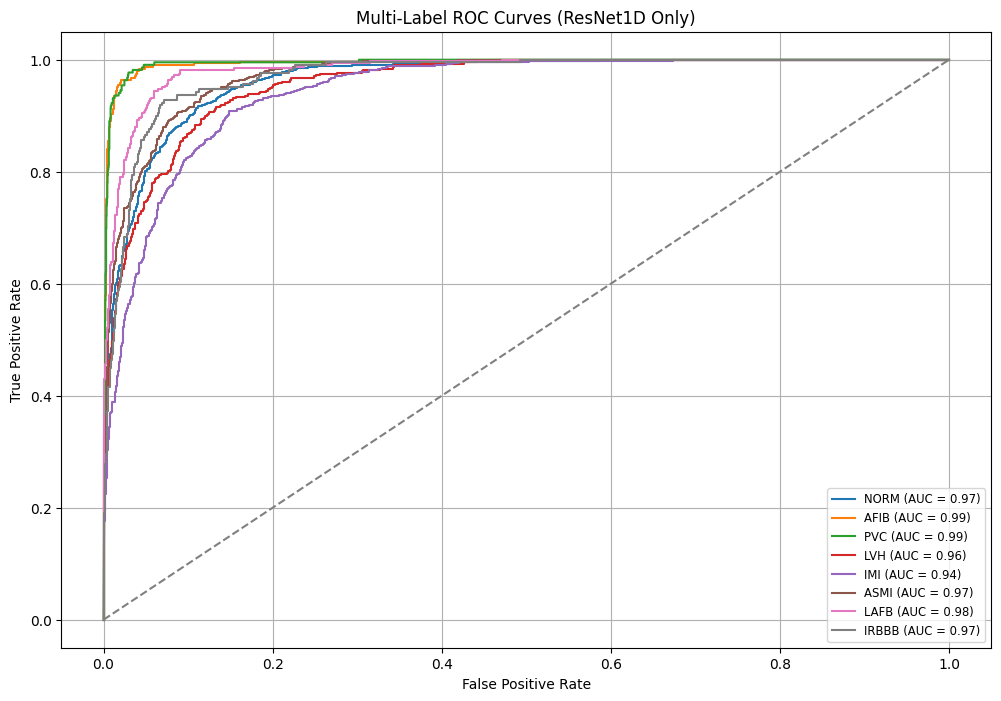

In [6]:
# Plot ROC Curves

plt.figure(figsize=(12, 8))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves (ResNet1D Only)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.show()


In [7]:
 # Helper function to compute macro-average ROC
def compute_macro_roc(y_true, y_pred):
    from sklearn.metrics import roc_curve, auc
    import numpy as np

    n_classes = y_true.shape[1]
    fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}

    for i in range(n_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    return all_fpr, mean_tpr, macro_auc

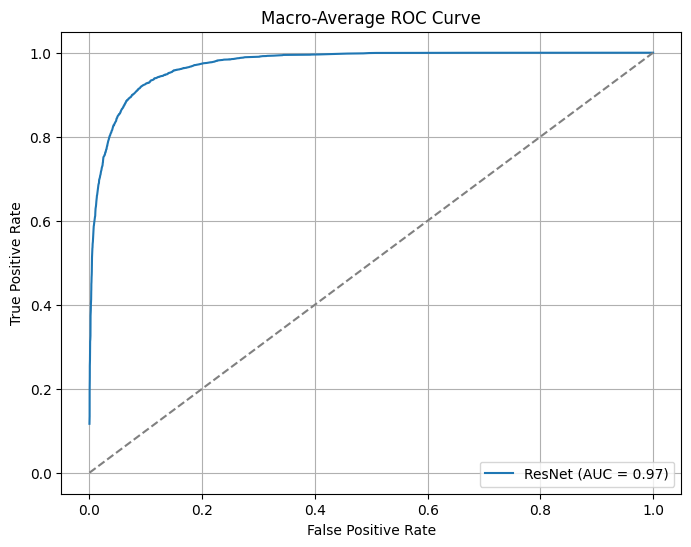

In [8]:
# Plot macro-average ROC
fpr, tpr, macro_auc = compute_macro_roc(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ResNet (AUC = {macro_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Macro-Average ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [9]:
import numpy as np

# After evaluation
np.save("y_true_resnet.npy", y_true)
np.save("y_pred_resnet.npy", y_pred)
